Copyright (c) University of Strasbourg. All Rights Reserved.
# MVOR
**A Multi-view RGB-D Operating Room Dataset for 2D and 3D Human Pose Estimation (MICCAI-LABELS-2018)**

_Vinkle Srivastav, Thibaut Issenhuth, Abdolrahim Kadkhodamohammadi, Michel de Mathelin, Afshin Gangi, Nicolas Padoy_

[![MVOR Dataset](https://img.shields.io/badge/MVOR-Dataset-blue)](http://camma.u-strasbg.fr/datasets/) [![arXiv](https://img.shields.io/badge/arxiv-1808.08180-red)](https://arxiv.org/abs/1808.08180) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CAMMA-public/MVOR/blob/master/mvor_demo.ipynb)


This demo notebook shows the 2D/3D ground truth visualization on a MVOR dataset and evaluations results.

**Code below needed only for the colab demo. Please make sure to enable "GPU" using EDIT->Notebook settings**

In [1]:
# Download the code, and the MVOR dataset
!git clone https://github.com/CAMMA-public/MVOR.git
%cd MVOR

!wget https://s3.unistra.fr/camma_public/datasets/mvor/camma_mvor_dataset.zip
!unzip -q camma_mvor_dataset.zip && rm camma_mvor_dataset.zip

Cloning into 'MVOR'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 71 (delta 10), reused 4 (delta 4), pack-reused 59 (from 1)
Receiving objects: 100% (71/71), 8.96 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/MVOR
--2025-01-19 13:02:32--  https://s3.unistra.fr/camma_public/datasets/mvor/camma_mvor_dataset.zip
Resolving s3.unistra.fr (s3.unistra.fr)... 130.79.200.152
Connecting to s3.unistra.fr (s3.unistra.fr)|130.79.200.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1395226000 (1.3G) [application/zip]
Saving to: ‘camma_mvor_dataset.zip’

camma_mvor_dataset. 100%[===================>]   1.30G  26.8MB/s    in 52s     

2025-01-19 13:03:26 (25.6 MB/s) - ‘camma_mvor_dataset.zip’ saved [1395226000/1395226000]



## Imports

In [2]:
import json
import random
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torchvision
import numpy as np
from IPython.display import display
from torchvision.transforms import functional as F
from PIL import Image
from mpl_toolkits.mplot3d.axes3d import Axes3D
from lib.visualize_groundtruth import create_index, viz2d, plt_imshow, bgr2rgb, plt_3dplot, coco_to_camma_kps, progress_bar
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
USE_GPU = True

if torch.cuda.is_available() and USE_GPU:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)

# Define the paths
DATASET_ROOT = "camma_mvor_dataset"
GT_ANNO_PATH = "annotations/camma_mvor_2018.json"

# load the ground truth annotations
camma_mvor_gt = json.load(open(GT_ANNO_PATH))
anno_2d, anno3d, mv_paths, imid_to_path = create_index(camma_mvor_gt)

Using device: cpu
creating index for 2D annotations
done
creating index for 3D annotations
Index creation done


## MVOR Stats

In [3]:
!python lib/show_stats.py --gt annotations/camma_mvor_2018.json

----------------------------------------------------------------------------------------------------------
Number of multi-view frames = 732
Number of person bounding boxes = 4699
Number of clinicians = 3925
Number of patients = 774
Number of faces visible = 2298
Number of 2D keypoint annotations = 2926
Number of 3D keypoint annotations = 1061
person[ Head Neck Shoulder-L Shoulder-R Hip-L Hip-R Elbow-L Elbow-R Wrist-L Wrist-R]
503   [ 495   497    418       464       395    419  320      391      260    299  ]=> No of person visible in all 3 views with each body part visibility
426   [ 419   424    385       392       354    354  278      294      191    205  ]=> No of person visible 2 views with each body part visibility
132   [ 127   129    125       128       119    125  86       96       55     60   ]=> No of person visible in 1 view with each body part visibility
----------------------------------------------------------------------------------------------------------


## Ground truth visualization

Visualizing the ground truth


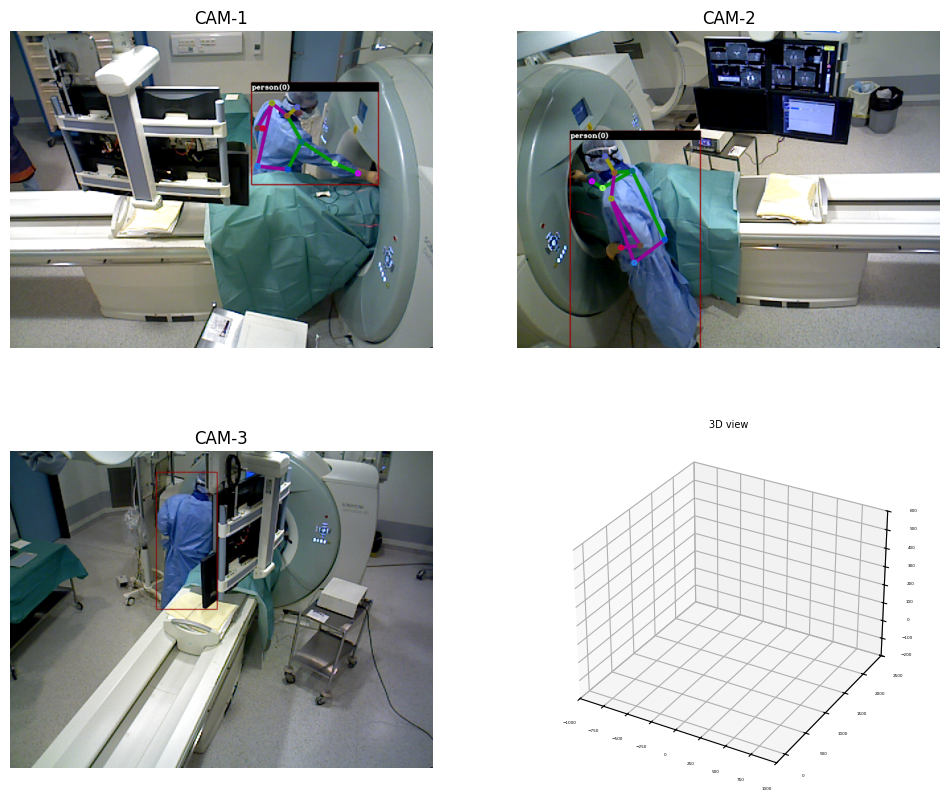

In [4]:
#imid_3d = "10010000013_10020000013_10030000013"
# Read a random multi-view image
imid_3d = random.choice(list(mv_paths.keys()))
imids_2d = [int(m) for m in imid_3d.split("_")]
imgs = [cv2.imread(os.path.join(DATASET_ROOT, imid_to_path[_p])) for _p in imids_2d]

# get the 2D and 3D annotation for the corresponding multi-view image
anns2d = [anno_2d[str(ann)] for ann in imids_2d]
anns3d = anno3d[imid_3d]

# Render 2d and 3D annotations
imgs_render_gt = [viz2d(im, ann) for im, ann in zip(imgs, anns2d)]
fig = plt.figure(figsize=(12,10))
print("Visualizing the ground truth")
fig.add_subplot(2, 2, 1); plt.imshow(bgr2rgb(imgs_render_gt[0])); plt.title("CAM-1"); plt.axis("off")
fig.add_subplot(2, 2, 2); plt.imshow(bgr2rgb(imgs_render_gt[1])); plt.title("CAM-2"); plt.axis("off")
fig.add_subplot(2, 2, 3); plt.imshow(bgr2rgb(imgs_render_gt[2])); plt.title("CAM-3"); plt.axis("off")
plt_3dplot(fig, anns3d, camma_mvor_gt)
plt.show()

**Run the above cell again to check the result on different multiview image**

## Visualizing the 2D predictions from the Keypoint-MaskRCNN model

Here we run a Keypoint-MaskRCNN model from [pytorch's torchvision library](https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) on the same multi-view image

In [ ]:
# load the model and pre-trained weights
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
# put the model on the eval mode and assign either "cpu" or "gpu" device
model.eval()
model = model.to(DEVICE)

# convert input multi-view images to pytorch tensors
imgs_tensor = [F.to_tensor(Image.open(os.path.join(DATASET_ROOT, imid_to_path[p])).convert('RGB')).to(DEVICE)
       for p in imids_2d]

# run the model on the multiview image
with torch.no_grad():
    predictions_2d = model(imgs_tensor)

# get the bounding boxes and keypoint detections
boxes = [pred["boxes"].cpu().numpy() for pred in predictions_2d]
keypoints = [pred["keypoints"].cpu().numpy() for pred in predictions_2d]

# put the results in the list for the visualization
all_anns = []
for bb, kps in zip(boxes, keypoints):
    anns = []
    for index, (b, kp) in enumerate(zip(bb, kps)):
        b = [b[0], b[1], b[2]-b[0], b[3]-b[1]]
        anns.append({"bbox": b, "keypoints": coco_to_camma_kps(kp), "person_id": index, "only_bbox": 0})
    all_anns.append(anns)

# render the results
imgs_render_pred = [viz2d(im, ann) for im, ann in zip(imgs, all_anns)]
fig = plt.figure(figsize=(20,18))
print("Visualizing the 2D predictions from the Keypoint-MaskRCNN model")
fig.add_subplot(1, 3, 1); plt.imshow(bgr2rgb(imgs_render_pred[0])); plt.title("CAM-1"); plt.axis("off")
fig.add_subplot(1, 3, 2); plt.imshow(bgr2rgb(imgs_render_pred[1])); plt.title("CAM-2"); plt.axis("off")
fig.add_subplot(1, 3, 3); plt.imshow(bgr2rgb(imgs_render_pred[2])); plt.title("CAM-3"); plt.axis("off")
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:03<00:00, 59.4MB/s]


## Evaluation of the Keypoint-MaskRCNN model on the MVOR dataset
Here, we evaluate the model for 2D person bounding box and 2D person keypoints on the MVOR dataset

In [ ]:
# Helper function for the evalution
@torch.no_grad()
def evaluate():
    print("Evaluating Keypoint-MaskRCNN on the MVOR dataset")
    bar = display(progress_bar(1, len(list(imid_to_path.keys()))), display_id=True)
    # list to store the results in coco format
    pred_results = []
    # iterating over each image
    for index, (im_id, path) in enumerate(imid_to_path.items()):
        # convert input image to pytorch tensor
        img = [F.to_tensor(Image.open(os.path.join(DATASET_ROOT, path)).convert('RGB')).to(DEVICE)]
        # forward propagation through the model
        pred_2d = model(img)
        # get the bounding box, keypoints, and scores from the prediction results
        boxes = pred_2d[0]["boxes"].cpu().numpy()
        keypoints = pred_2d[0]["keypoints"].cpu().numpy()
        scores = pred_2d[0]["scores"].cpu().numpy()

        # update the results in coco format
        for box, kps, sc in zip(boxes, keypoints, scores):
            camma_kps = [float(_a) for _a in coco_to_camma_kps(kps).reshape(-1).flatten().tolist()]
            coco_kps = [float(_a) for _a in kps.reshape(-1).flatten().tolist()]
            box = [float(b) for b in box]
            pred_results.append({
                "image_id": int(im_id),
                "category_id": "1",
                "bbox": [box[0], box[1], box[2]-box[0], box[3]-box[1]],
                "keypoints":camma_kps,
                "coco_keypoints":coco_kps,
                "score": float(sc)
            })
        bar.update(progress_bar(index + 1, len(list(imid_to_path.keys()))))
    return pred_results

# call the function for evaluation
pred_results = evaluate()

print("Writing result in the coco format\n")
with open("keypoint_maskrcnn_pred_results.json", "w") as f:
    json.dump(pred_results, f)

# Evaluation for 2D person bounding box
print("--------------------------------------------------------------------")
print("2D person bounding box results for the Keypoint-MaskRCNN model")
!python lib/eval_ap_2dperson.py --gt annotations/camma_mvor_2018.json --dt keypoint_maskrcnn_pred_results.json
print("--------------------------------------------------------------------\n")
# Evaluation for 2D person keypoints
print("--------------------------------------------------------------------")
print("2D person keypoints results for the Keypoint-MaskRCNN model\n")
!python lib/eval_pck_2dpose.py --gt annotations/camma_mvor_2018.json --dt keypoint_maskrcnn_pred_results.json
print("--------------------------------------------------------------------")

## 2D pose estimation evaluation results
Here, we provide results for 2D keypoints from the json files obtained by running the 2D keypoint detectors on the MVOR dataset

In [ ]:
# openpose
print("Evaluation results for the OpenPose")
!python lib/eval_pck_2dpose.py --gt annotations/camma_mvor_2018.json --dt detections_results/openpose_kps.json

# openpose with multiscale testing
print("Evaluation results for the OpenPose with multi-scale testing")
!python lib/eval_pck_2dpose.py --gt annotations/camma_mvor_2018.json --dt detections_results/openpose_kps_multiscale.json

# alphapose
print("Evaluation results for the AlphaPose")
!python lib/eval_pck_2dpose.py --gt annotations/camma_mvor_2018.json --dt detections_results/alphapose_kps.json

# rtpose
print("Evaluation results for the RTPose")
!python lib/eval_pck_2dpose.py --gt annotations/camma_mvor_2018.json --dt detections_results/rtpose_kps.json

## 2D person bounding box detection evaluation results
Here, we provide results for 2D person bounding box from the json files obtained by running the 2D person bounding box on the MVOR dataset

In [ ]:
# faster rcnn
print("\n--------------------------------------------------------------------")
print("Evaluation results for the Faster-RCNN")
print("--------------------------------------------------------------------")
!python3 lib/eval_ap_2dperson.py --gt annotations/camma_mvor_2018.json --dt detections_results/faster_rcnn_bbox.json

# deformable conv-nets R-FCN
print("\n--------------------------------------------------------------------")
print("Evaluation results for the deformable conv-nets R-FCN")
print("--------------------------------------------------------------------")
!python3 lib/eval_ap_2dperson.py --gt annotations/camma_mvor_2018.json --dt detections_results/dfcnet_rfcn_bbox.json

2D person boudning box detection from keypoints (here, the AR is not averaged over IoU in [0.50, 0.55, ..., 0.95], it is only given for IoU = 0.50)

In [ ]:
# openpose default
print("\n--------------------------------------------------------------------")
print("Evaluation results for the OpenPose")
print("--------------------------------------------------------------------")
!python lib/eval_ap_2dperson.py --gt annotations/camma_mvor_2018.json --dt detections_results/openpose_bbox.json

# openpose multiscale
print("\n--------------------------------------------------------------------")
print("Evaluation results for the OpenPose mult-scale")
print("--------------------------------------------------------------------")
!python lib/eval_ap_2dperson.py --gt annotations/camma_mvor_2018.json --dt detections_results/openpose_bbox_multiscale.json

# alphapose default
print("\n--------------------------------------------------------------------")
print("Evaluation results for the AlphaPose")
print("--------------------------------------------------------------------")
!python lib/eval_ap_2dperson.py --gt annotations/camma_mvor_2018.json --dt detections_results/alphapose_bbox.json

# rtpose
print("\n--------------------------------------------------------------------")
print("Evaluation results for the RTPose")
print("--------------------------------------------------------------------")
!python lib/eval_ap_2dperson.py --gt annotations/camma_mvor_2018.json --dt detections_results/rtpose_bbox.json